In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

import matplotlib.pyplot as plt

import numpy as onp

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as np


# Using an RDF as a scoring function. 

An EDM could come from points in many dimensions, so it's possible that there are multiple weird ways to satisfy any given EDM. These ways would all be consistent with other EDMs, and so the network will be happy, but the actual 3D realisation of those EDMs might _do not_ work how we expect. 

Alternatively, if we directly learn 3D coordinates, and then compare the euclidean distances to a known distribution, then the network is forced to make the distances consistent with what we expect in 3D space. Put another way, the network can't just put all atoms at the same distance as a carbon-carbon bond distance, because there is not enough volume in 3d dimensions to fit all the atoms surrounding the central atom. The surrounding atoms will thus be forced to move outwards, and hopefully it all settles on a reasonable-looking molecule.  

The below fits a loss function using the distributions of known atom distances. 

The network part uses JAX numpy, hence the original numpy is re-nicknamed `onp`.

In [2]:
##load dataset of QM9 isomers. 
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

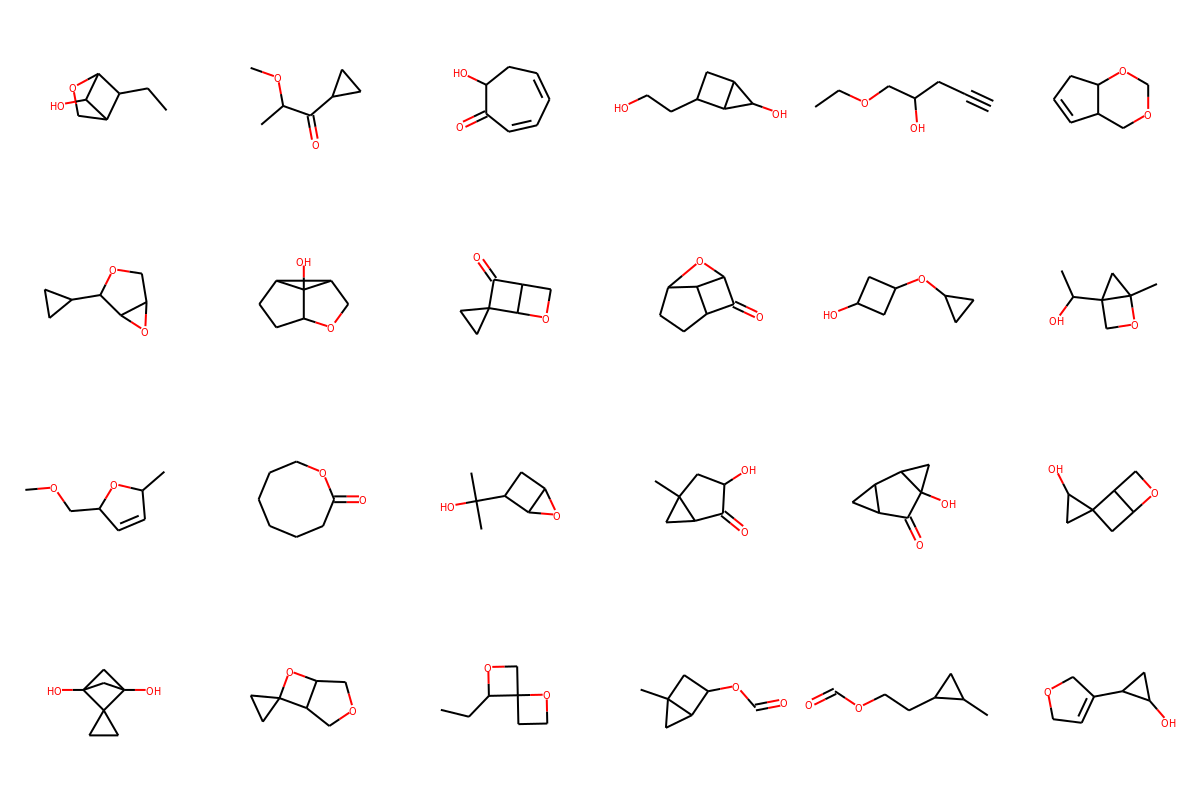

In [3]:
###draw sample
Draw.MolsToGridImage(onp.random.choice(onp.array(mols), 24), molsPerRow=6)


In [4]:
###Calculates 3d coordinates of a molecule using RDKit, and then gets a euclidean distance matrix. 
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None

In [5]:
def returncoords(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
    
def squared_exponential(distance):
    return onp.exp(distance**2 / (-3))

###Run through molecules and make the EDM dataset. 
coordinates = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 4000)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        #get atom identities as 0(carbon) or oxygen(1)
        atoms = onp.clip(onp.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
        sort_indices = onp.argsort(onp.array(atoms, dtype=bool))
        points = points[sort_indices]
        
        coordinates.append(points)



In [6]:
coordinates = np.array(coordinates)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:

edms = list()
eigvals = list()
adjacencies = list()

for p in coordinates:
    edm = pdist(p)
    edms.append(edm)
    edm = squareform(edm)
    
    A = squared_exponential(edm)-onp.eye(9)
    adjacencies.append(np.sum(A,axis=0))
        
    D = onp.sum(A, axis=0)*onp.eye(9)
    L = D-A
    eigval, evecs = onp.linalg.eigh(L)
    eigvals.append(eigval)
   

edms = np.array(edms)
eigvals = np.array(eigvals)
adjacencies = np.array(adjacencies)


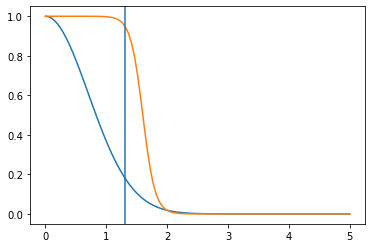

In [996]:
import jax.numpy as np
from jax.config import config
from jax import jit, grad, lax, random, vmap
from jax.ops import index_update, index, index_add

x = np.linspace(0,5, 100)
@jit
def squared_exponential(distance):
    return np.exp(distance**2 / (-1))

@jit 
def jax_squareform(edm):
    empty = np.zeros([9,9])
    half = index_add(empty, index[np.triu_indices(9,1)], edm)
    full = half+half.T
    return full

@jit
def calcRDF(data, bins=201, sigma=0.15):
    exp = np.exp(-0.5 * (data[:, np.newaxis] -np.linspace(0., 9, bins)) ** 2 / sigma** 2)
    gaussian_distances = (exp / np.sqrt(2 * np.pi * sigma ** 2))
    rdf = np.mean(gaussian_distances, axis=0)
    return rdf / np.sum(rdf)*(100)

@jit
def sigm(x, k=10, offset=1.6):
    return 1-1/(1 + np.exp(-k*(x-offset))) 



@jit
def getConnectivity(d_i):    
    A = sigm(d_i)-np.eye(9)
    #lt = np.array(np.less_equal(d_i, 1.8), dtype='int32')
    #gt = np.array(np.greater_equal(d_i, 0.01), dtype='int32')
    #A = np.bitwise_and(lt, gt)
    D = np.sum(A, axis=0)*np.eye(9)
    L = D-A
    evals, evecs = np.linalg.eigh(L)
    return evals, np.sum(A, axis=0)

getFlatDistance = jit(lambda d_in: d_in[np.triu_indices(9,1)])


plt.plot(x, squared_exponential(x))
plt.plot(x, sigm(x,10, 1.6))
plt.axvline(1.3)


eigvals, adjacencies = vmap(getConnectivity)(vmap(jax_squareform)(edms))
true_eigvals = np.cumsum(vmap(calcRDF, in_axes=0)(eigvals.T), axis=1)
#true_adjacencies = np.cumsum(vmap(calcRDF, in_axes=0)(adjacencies.T), axis=1)


In [806]:
dummy = onp.random.uniform(0,9,(1000,9))
pos = np.ones(len(flatsummed_edms))
neg = np.zeros(1000)

@jit
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2) + 1)

# Outputs probability of a label being true.
@jit
def predict(theta, inputs):
    return sigmoid(np.dot(inputs, theta[:9]) + theta[9])

# Build a toy dataset.
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])
print(inputs.shape)
print(targets.shape)
inputs = np.concatenate([dummy, flatsummed_edms])
targets = np.array(np.concatenate([neg,pos]), dtype='bool')

print(inputs.shape)
print(targets.shape)

# Training loss is the negative log-likelihood of the training examples.
@jit
def loss(W, inputs):
    preds = predict(W, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(label_probs))



(4, 3)
(4,)
(4622, 9)
(4622,)


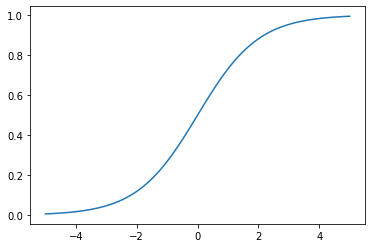

In [807]:
x = np.linspace(-5,5,100)
plt.plot(x,sigmoid(x))

In [808]:
np.dot(inputs, W[:9]) + W[9]

DeviceArray([ -5.046422 ,  -8.820986 , -10.262972 , ...,   3.756312 ,
               3.8854833,   4.130368 ], dtype=float32)

In [819]:
# Initialize random model coefficients
key, W_key = random.split(key, )
W = random.normal(W_key, (10,))
#b = random.normal(b_key, ())

W

DeviceArray([-0.8662187 ,  0.02913723,  0.7047067 ,  0.30584338,
              0.55629236, -0.40035287, -0.5837913 , -1.286926  ,
             -0.6087783 ,  0.7362824 ], dtype=float32)

In [820]:


wlist = list()
for n in tqdm_notebook(range(100000)):#itertools.count():

    # Get the gradient of the loss for this input/output pair
    W_grads = grad(loss, argnums=0)(W, inputs)
    if n%100==0:
        print(W_grads, end='\r')
    
    # Update parameters via gradient descent
    W = W - 0.000001 * W_grads
    wlist.append(W)
    
wlist = np.array(wlist)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[-3055.2053 -5596.1777 -4966.8887 -5096.2676 -4881.685  -5114.704
[ -71.18821 -487.9229   108.33678 -183.25253   35.53828 -472.44028
[  94.17343 -196.34308  346.11493   79.40114  277.2764  -204.25415
[  83.02114  -160.24335   339.3191     95.962685  275.51526  -175.65195
[  64.98787 -138.7272   321.43127   99.55994  262.3692  -160.21257
[  48.47052  -119.61563   304.0628    101.917984  249.44157  -146.52353
[  33.748272 -102.18344   287.78754   103.71203   237.30498  -133.94351
[  20.6818    -86.29487   272.6066    105.00844   225.95091  -122.37732
[   9.121911  -71.84704   258.4833    105.876114  215.34119  -111.7585
 -138.99466  -154.82874    17.844082 -463.7943  ]
[  -1.0724646  -58.746937   245.3691     106.33882    205.4336
[ -10.056208   -46.894604   233.19778    106.44606    196.14911  ]
[ -17.960909   -36.181976   221.89658    106.22466    187.44665  ]
[ -24.914276   -26.510324   211.3992     105.71658    179.27883  ]
[ -31.023764   -17.778927   201.62402    104.95168    171.58

[  -3.1075194   15.225181    13.267638    10.040709     9.350157 ]
[  -2.9291704   15.015276    13.098066     9.908691     9.224861 ]
[  -2.7580895   14.810427    12.932906     9.777459     9.1018505]
[  -2.5919003   14.613323    12.774965     9.653853     8.984211 ]
[  -2.4342108   14.418766    12.61868      9.531003     8.867696 ]
[  -2.2789924   14.231756    12.468066     9.416317     8.758732 ]
[  -2.132378    14.045325    12.320861     9.299144     8.647939 ]
[  -1.9895395    13.867605     12.17817       9.187462      8.543161
[  -1.8533094    13.692866     12.036313      9.079428      8.438745  ]
[  -1.7211744    13.522455     11.9023285     8.971997      8.338337  ]
[-1.5922419e+00  1.3357656e+01  1.1771921e+01  8.8712854e+008.75601   ]
  8.2431564e+00  9.3402033e+00  6.6900945e+00 -8.8281475e-02
[-1.4708266e+00  1.3194401e+01  1.1639562e+01  8.7694530e+00
  8.1462431e+00  9.2740116e+00  6.6442962e+00  4.8207562e-02
[  -1.35283     13.035145    11.512853     8.671742     8.05292

[   2.0455673    5.956411     5.840331     4.246379     3.8583307]
[   2.0509267    5.924839     5.8151164    4.2269206    3.8386204]
[   2.0567706    5.8952823    5.7914567    4.209606     3.820341 ]
[   2.0606792    5.8636622    5.7647433    4.1892653    3.801348 ]
[   2.0645018    5.830308     5.738503     4.166389     3.7797937]
[   2.069163     5.798721     5.7116227    4.1469564    3.760911 ]
[   2.0720668    5.7664914    5.686945     4.1258135    3.7397878]
[   2.076008     5.7381167    5.6628838    4.107907     3.7228708]
[   2.0821395    5.712552     5.642743     4.0931544    3.7082992]
[   2.0857596    5.6830096    5.61967      4.0744543    3.689787 ]
[   2.0883582    5.653012     5.594588     4.0547       3.669989 ]
[   2.092834     5.6242647    5.571996     4.0381675    3.653525 ]
[   2.0979636    5.5978923    5.5502663    4.020854     3.6382344]
[   2.10306      5.571789     5.530784     4.0054393    3.6222856]
[   2.102428     5.5392346    5.503113     3.9836152    3.6007

[  2.1237266   3.6522856   3.9733424   2.8003838   2.40212     3.975461
[  2.1225834   3.639449    3.9636097   2.7915971   2.3938243   3.9661963
[  2.123587    3.629094    3.9555776   2.7867706   2.3882208   3.9585757
[  2.1191554   3.612384    3.9412062   2.7750063   2.3756042   3.9451811
[  2.1211586   3.604032    3.9347317   2.7716098   2.3723257   3.939152
[  2.1184177   3.5899017   3.9230332   2.761949    2.3624377   3.9277549
[  2.1188297   3.5797343   3.9153447   2.7558303   2.3566134   3.9203253
[  2.119109    3.5707781   3.907558    2.7509181   2.3507745   3.9126177
[  2.1139727   3.5525115   3.8923476   2.7378488   2.338207    3.8979928
[  2.114852    3.5439284   3.886106    2.7343583   2.3337283   3.8931541
[  2.1116734   3.5301886   3.873783    2.7235222   2.3230317   3.8801427
[  2.1107712   3.5182402   3.8647535   2.7166922   2.315911    3.87169
[  2.1121204   3.5114503   3.859282    2.7136729   2.3121235   3.8659422
[  2.106504    3.492244    3.843414    2.7003338   2.29

[  1.935778    2.5855386   3.0909414   2.1308556   1.6973433   3.1105812
[  1.9336231   2.5772526   3.0833375   2.1248193   1.6909341   3.1033976
[  1.9338976   2.5719318   3.0795996   2.1222637   1.6882987   3.0990973
[  1.9355353   2.5693393   3.0770998   2.12211     1.6882979   3.096991
[  1.933945    2.5618715   3.0712602   2.1170213   1.6830629   3.0904398
[  1.9298725   2.550614    3.060638    2.1088524   1.6745273   3.0802033
[  1.9300814   2.54587     3.0573277   2.1067007   1.6722916   3.077159
[  1.9304644   2.542192    3.05433     2.1050146   1.6703813   3.0742643
[  1.9309611   2.5377817   3.05094     2.103781    1.668034    3.070759
[  1.9237338   2.5221796   3.0362227   2.0902297   1.654706    3.056732
[  1.9216218   2.5147517   3.0300803   2.0854397   1.6493285   3.0506876
[  1.921501    2.5102158   3.0262725   2.083498    1.6470902   3.0471022
[  1.9225639   2.5079486   3.024751    2.0830803   1.6468935   3.0455523
[  1.9178119   2.4954677   3.0141208   2.0736673   1.63

[  1.7407094   1.9686815   2.5539467   1.7313479   1.2759261   2.5695152
[  1.7412387   1.9684933   2.5538747   1.7317225   1.2761124   2.5686362
[  1.7421191   1.9668425   2.5521617   1.7322769   1.2758427   2.5680432
[  1.7431513   1.9655818   2.5515614   1.7321649   1.275772    2.5671976
[  1.7439778   1.9649557   2.550664    1.7324834   1.275979    2.5664628
[  1.7448952   1.9641075   2.5497277   1.7330259   1.2757034   2.565876
[  1.7458879   1.9630444   2.5491107   1.7332294   1.275882    2.565317
[  1.7466897   1.9619133   2.5480762   1.733948    1.2757391   2.5644867
[  1.7421741   1.9520487   2.5394526   1.7257591   1.2675213   2.5556931
[  1.7325784   1.9349475   2.5229754   1.7109783   1.2526146   2.5395522
[  1.7273382   1.9254475   2.5139496   1.70292     1.2439293   2.5308876
[  1.7261459   1.9219205   2.5111861   1.7001557   1.2416756   2.5269578
[  1.724625    1.9184687   2.5084124   1.6981901   1.2397059   2.5235617
[  1.7235279   1.9148871   2.5054939   1.6960909   1.

[  1.59651     1.602422    2.220154    1.4903718   1.024152    2.2266076
[  1.5969112   1.6020585   2.2204442   1.4910344   1.0243009   2.2264583
[  1.585033    1.5827386   2.2021353   1.4734371   1.0065237   2.2091498
[  1.5773077    1.57018      2.1896174    1.4622363    0.99532384
[  1.5746604    1.5650663    2.1845863    1.4573091    0.99123615]
[  1.5743824    1.5622544    2.182249     1.4561396    0.98965967]
[  1.5742717    1.5612687    2.181129     1.4554108    0.98887116]
[  1.5740697   1.559451    2.1796958   1.4548604   0.9886788   2.186488
[  1.5739053    1.5577699    2.1774974    1.4541488    0.98815125
[  1.5744936   1.5570067   2.1771321   1.4537808   0.9884537   2.1850195
[  1.5752257    1.557102     2.1765091    1.4540054    0.9895178
[  1.5762875    1.557083     2.1766036    1.4547511    0.99011105]
[  1.5770111    1.556722     2.1767104    1.4552912    0.99079025]
[  1.5777211    1.5567617    2.1757755    1.4559673    0.9909322 ]
[  1.5782635    1.5561111    2.175303

[  1.4602325    1.3188177    1.9437048    1.2891862    0.82215947]
[  1.4601512   1.3183051   1.9437168   1.2891716   0.8225159   1.9516585
[  1.4602597    1.3181837    1.943503     1.2892215    0.8226045
[  1.4604176    1.3186241    1.9438338    1.289739     0.82296073]
[  1.4602945    1.3185009    1.9434721    1.2896426    0.82326734]
[  1.4602746    1.3185999    1.9429836    1.2897593    0.82310724]
[  1.4603552    1.3182703    1.9438219    1.2899007    0.82350767]
[  1.4604269   1.3184191   1.9437637   1.289846    0.823703    1.9517483
[  1.4604982   1.3182749   1.943627    1.2898241   0.8238045   1.9513259
[  1.458443     1.3155336    1.9407302    1.2873054    0.8212462
[  1.4472102    1.2967213    1.9226733    1.2697836    0.80411804]
[  1.4396294   1.2839922   1.9106029   1.2586578   0.7929384   1.9193085
[  1.4351426    1.2774442    1.9035379    1.2525069    0.7867226
[  1.4319901    1.2719878    1.8979906    1.247466     0.78172505]
[  1.4303843   1.2696184   1.8949221   1.245

[  1.3410773    1.1258347    1.7433959    1.1454087    0.68377286]
[  1.3412148   1.1262728   1.7434511   1.1460878   0.684116    1.7514802
[  1.3411784   1.1262053   1.7436402   1.1462387   0.6846445   1.751238
[  1.3405365    1.1251525    1.7429665    1.1455675    0.68377215
[  1.3318759   1.1110336   1.7290089   1.1321177   0.6704403   1.7368765
[  1.3252147    1.0998093    1.717854     1.1218593    0.66040623
[  1.320674     1.0922835    1.7103424    1.1145511    0.6535716 ]
[  1.318547     1.0885456    1.7066741    1.1114355    0.6505725 ]
[  1.3177595    1.0872816    1.7054291    1.1105975    0.6494366 ]
[  1.317936    1.0872236   1.7052504   1.1106081   0.6503007   1.7134988
[  1.3182204   1.0872775   1.70522     1.1110694   0.6505029   1.7135227
[  1.3182462    1.087678     1.7048571    1.111183     0.650842
[  1.3184173    1.0876826    1.7050567    1.1115116    0.65139586]
[  1.3186901    1.0875908    1.7049416    1.111758     0.65200233]
[  1.3191156    1.0882648    1.7052504

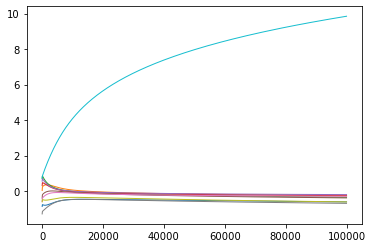

In [821]:
plt.plot(wlist[:,], linewidth=1)

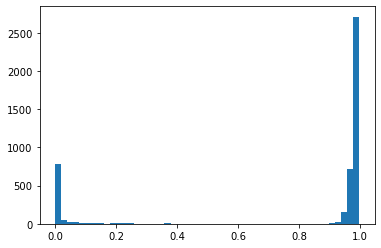

In [822]:
_ =plt.hist(predict(W, inputs), bins=50)

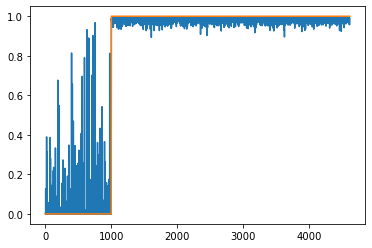

In [823]:
plt.plot(predict(W, inputs))
plt.plot(targets)

So, the adjacency values and eigenvalues of Laplacian are given by getConnectivity.
Then, one must get the indices of the adjacency values to 

In [539]:
flatsum = lambda edm: np.sum(jax_squareform(sigm(edm)), axis=0)
flatsummed_edms = vmap(flatsum)(edms)

adjacency_distributions = vmap(calcRDF)(flatsummed_edms.T)

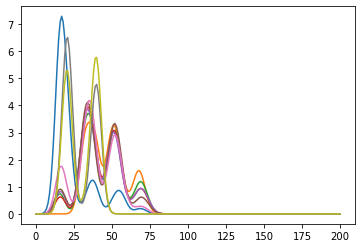

In [540]:
plt.plot(adjacency_distributions.T)

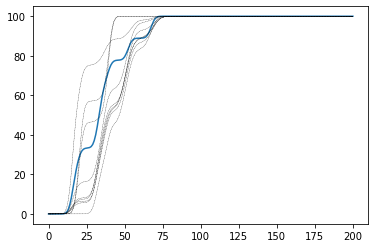

In [441]:
plt.plot(np.cumsum(calcRDF(flatsummed_edms[0])))
plt.plot(adjacency_distributions.T, c='k', linestyle='--', linewidth=0.3)


(array([ 52., 164., 414., 658., 780., 707., 509., 251.,  74.,  13.]),
 array([0.02340134, 0.03940294, 0.05540453, 0.07140612, 0.08740771,
        0.10340931, 0.11941089, 0.13541248, 0.15141408, 0.16741566,
        0.18341726], dtype=float32),
 <a list of 10 Patch objects>)

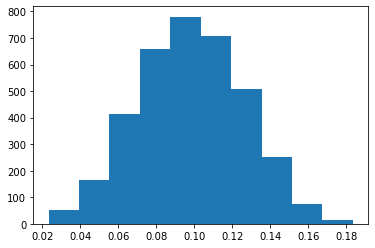

In [181]:
plt.hist(probabilities)

0.017678842


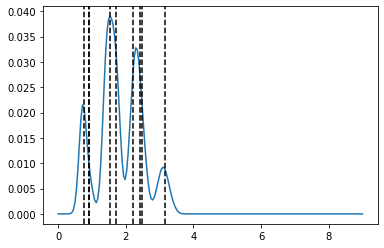

In [137]:
print(probs[56])
plt.plot(np.linspace(0,9,201), probs)
for boop in indices:
    plt.axvline(np.linspace(0,9,201)[boop], linestyle='--', c='k')

# Can we use this loss function in a neural net?

Using jax.stax here for the net. The idea is to generate coordinates from noise (i.e. latent coordinates like a GAN or a VAE) and to take the loss function as defined above (i.e. the inverse of the gmm density)

The code below borrows from two good examples:


There is a great tutorial for doing this: MAML with JAX: https://github.com/ericjang/maml-jax/blob/master/maml.ipynb with more depth explanation at: https://blog.evjang.com/2019/02/maml-jax.html

However some of the code is old. So, also using: https://github.com/google/jax/blob/master/examples/mnist_vae.py which seems more similar to the current task but has no explanation. 

In [205]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, lax, random, vmap, value_and_grad
from jax.experimental import optimizers, stax
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu, Dropout, Gelu, Sigmoid
from jax.nn.initializers import he_uniform

In [206]:
##Amazing resource to quickly take distance matrix of any-dimensional data;
##https://github.com/google/jax/issues/787

#normal:
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

#apparently faster? uses cosine trick.
##However it is susceptible to NaNs. Not using it for this reason.
#@jit
#def E_fn(conf):
#    norms = np.sum(conf ** 2, -1)
#    dij = np.sqrt(norms[..., None] + norms - 2 * np.dot(conf, conf.T))
#    return dij

##Example usage to get pairwise distances of coords or noises:
#E_fn(coords)[np.triu_indices(numsamples, 1)]

##The intuition is explained here:
#https://arxiv.org/abs/1901.09024
#Basically, you want the pairwise distance between any two points
#in latent space to be similar to the pairwise distance between 
#any two points in 3d-coordinate space. To do this, you tell the network
#to maximise the similarity between coordinate-coordinate distance
#and latent-latent distance. 


In [1246]:
def init_my_network(latent_dims=50):
    test_rng = random.PRNGKey(1)
    layer_sizes = [784, 1024, 1024, 10]
    _, dec_init_rng = random.split(random.PRNGKey(2))
    decoder_init, decode = stax.serial(
        Dense(2048, W_init=he_uniform()), Relu, 
        ##Dropout(0.8),
        Dense(1024, W_init=he_uniform()), Relu, 
        ##Dropout(0.8),
        Dense(512, W_init=he_uniform()), Relu, 
        ##Dropout(0.8),
        Dense(256, W_init=he_uniform()), Relu, 
        ##Dropout(0.8),
        Dense(128, W_init=he_uniform()), Relu, 
        ##Dropout(0.8),
        
        #Dense(36), Gelu, 
        #Dense(36), Gelu, 
        #Dense(36), Gelu, 
        #Dense(36), Gelu, 
        #Dense(36), Gelu, 
        #Dense(36), Gelu, 
        Dense(27))

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, latent_dims))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

@jit
def makeEDM(params, noises, key):
    coords = decode(params, noises, rng=key)
    return coords #return the square matrix

@jit
def pairwise_distances(coords_in):
    xyz1 = coords_in.reshape(9,3)
    d0 = np.abs(xyz1[:,0].reshape([-1,1]) - xyz1[:,0])
    d1 = np.abs(xyz1[:,1].reshape([-1,1]) - xyz1[:,1])
    d2 = np.abs(xyz1[:,2].reshape([-1,1]) - xyz1[:,2])
    return (d0+d1+d2)[np.triu_indices(9,1)]


flatsum = jit(lambda edm: np.sum(jax_squareform(sigm(edm)),axis=0))
fetch_scores = lambda ind, adj:  adj[[0,1,2,3,4,5,6,7,8],[ind]][0]
get_coords = jit(lambda params, noises, key: decode(params, noises, rng=key))
true_rdf = calcRDF(edms.flatten())

@jit
def loss(p_input, noises_input, key):
    #get the coords:
    many_coords = vmap(get_coords, in_axes=(None,0,None))(p_input, noises_input, key)*5
    
    many_EDMs = vmap(pairwise_distances, in_axes=(0))(many_coords)
    ##get the distances. 
    #many_EDMs = np.abs(batched_makeEDM(p_input, noises_input, key))*4
    
    ##First measure the per molecule probabilities
    flatsummed_EDMs = vmap(flatsum)(many_EDMs)
    
    
    batch_eigvals, batch_adjacencies = vmap(getConnectivity)(vmap(jax_squareform)(many_EDMs))
    eigval_loss = np.mean((np.cumsum( (vmap(calcRDF, in_axes=0)(batch_eigvals.T)), axis=1)-true_eigvals)**2)

    
    noise_distances = E_fn(many_EDMs)[np.triu_indices(noises.shape[0], 1)]
    instance_distances = E_fn(many_coords)[np.triu_indices(noises.shape[0], 1)]
    diversity_loss = np.mean((instance_distances/np.max(instance_distances) / noise_distances/np.max(noise_distances)))
    
    coordinate_loss = (np.mean(many_coords, axis=0)**2).mean() + ((1.0465-np.std(many_coords, axis=0))**2).mean()
    
    return np.mean(1-predict(W, flatsummed_EDMs))*100+eigval_loss+diversity_loss*100 +coordinate_loss*100
    #indices = np.round(flatsummed_EDMs/0.045).astype('int32')
    #per_mol_prob = -np.mean(vmap(fetch_scores, in_axes=(0,None))(indices, adjacency_distributions))
    
    ##then measure the population RDF:
    pred_rdf = calcRDF(many_EDMs.flatten())
    rdf_loss = np.mean((true_rdf-pred_rdf)**2)
    
    return rdf_loss+per_mol_prob
    #losses = 
    #ecdfs = vmap(calcRDF)(flatsummed_edms.T)
    
    #per_atom_ecdf_loss = np.mean((ecdfs - ))

    
    
    

batched_makeEDM = vmap(makeEDM, in_axes=(None, 0, None))
#batched_pairwiseDistances = vmap(pairwise_distances, in_axes=(0))
gradient_of_loss = grad(loss)

In [1247]:
latent_dims = 10
opt_state, opt_update, decode, get_params = init_my_network(latent_dims=latent_dims)

key = random.PRNGKey(3)
key, noise_key = random.split(key)

loss_list = list()

get_loss_and_grad = lambda p_in, noises_in, key: value_and_grad(loss)(p_in, noises_in, key)

def step(i, opt_state, key):
    key, noise_key = random.split(key)
    noises = random.normal(noise_key, shape=(512, latent_dims))
    p = get_params(opt_state)   
    l,g = get_loss_and_grad(p, noises, key)
    if i%1==0:
        loss_list.append(l)
        print(l, end='\r')
    return opt_update(i, g, opt_state), key



In [ ]:
for i in tqdm_notebook(range(100000)):
    opt_state, key = step(i, opt_state, key)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [1100]:



key, noise_key = random.split(key)  
noises = random.normal(noise_key, shape=(512, latent_dims))
p = get_params(opt_state)   
#loss(p, noises, key)

In [1101]:
#get the coords:
many_coords = vmap(get_coords, in_axes=(None,0,None))(p, noises, key)*5
many_EDMs = vmap(pairwise_distances, in_axes=(0))(many_coords)
flatsummed_EDMs = vmap(flatsum)(many_EDMs)
batch_eigvals, batch_adjacencies = vmap(getConnectivity)(vmap(jax_squareform)(many_EDMs))
eigval_loss = np.mean((np.cumsum( (vmap(calcRDF, in_axes=0)(batch_eigvals.T)), axis=1)-true_eigvals)**2)


In [1245]:
eigval_loss

DeviceArray(0.9207671, dtype=float32)

In [1102]:

noise_distances = E_fn(many_EDMs)[np.triu_indices(noises.shape[0], 1)]
instance_distances = E_fn(many_coords)[np.triu_indices(noises.shape[0], 1)]
diversity_loss = np.mean((instance_distances/np.max(instance_distances) / noise_distances/np.max(noise_distances)))
    

In [1103]:
E_fn(flat_edms)

DeviceArray([24.255217, 26.301954, 33.74748 , ..., 21.602678, 23.590975,
             24.609993], dtype=float32)

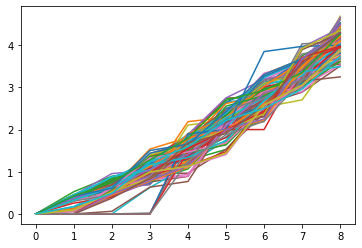

In [1104]:
_ = plt.plot(batch_eigvals[0:100].T)

In [1105]:
batch_eigvals, batch_adjacencies = vmap(getConnectivity)(vmap(jax_squareform)(many_EDMs))

In [1106]:
boop = vmap(calcRDF, in_axes=0)(batch_eigvals.T)

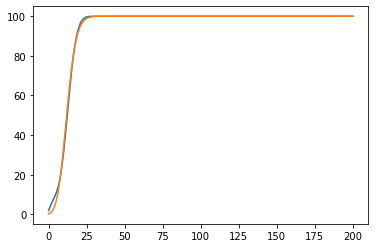

In [1107]:
plt.plot(np.cumsum( (vmap(calcRDF, in_axes=0)(batch_eigvals.T)), axis=1)[2])
plt.plot(true_eigvals[2])

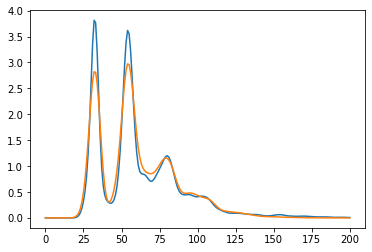

In [1109]:
plt.plot(pred_rdf)
plt.plot(true_rdf)

In [1110]:
np.sum((pred_rdf-true_rdf)**2)

DeviceArray(5.865491, dtype=float32)

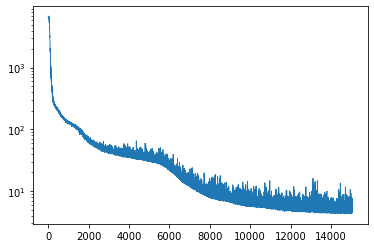

In [1111]:
#plt.plot(onp.log(loss_list), linewidth=0.1)
loss_list = np.array(loss_list)
plt.plot(loss_list+2, linewidth=0.9)
plt.yscale('log')

Actual coordinates:

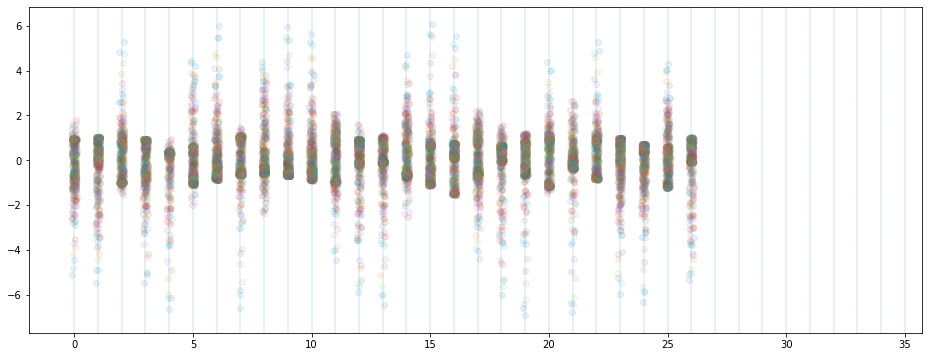

In [1115]:
plt.figure(figsize=(16,6))

for e in many_coords:
    plt.scatter(np.arange(27)+onp.random.uniform(-0.1,0.1,27), e, alpha=0.1)
#plt.ylim(-1,3)
#plt.xlim(0,4)
for k in range(36):
    plt.axvline(k, linestyle='--', linewidth=0.3)

Adjacency loss:

In [1116]:
batch_eigvals, batch_adjacencies =vmap(getConnectivity)(vmap(jax_squareform)(many_EDMs))

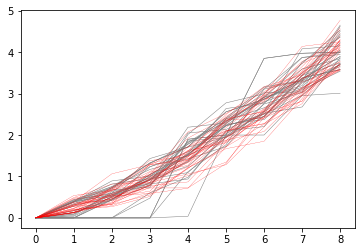

In [1117]:
for i in onp.random.randint(0, 512, 30):
    plt.plot(batch_eigvals[i], linewidth=0.5, c='gray')
    
for i in onp.random.randint(0, 512, 30):
    plt.plot(eigvals[i], linewidth=0.2, c='red')

In [1118]:
flatsummed_batch_edms = vmap(flatsum)(many_EDMs)

adjacency_distributions = vmap(calcRDF)(flatsummed_batch_edms.T)

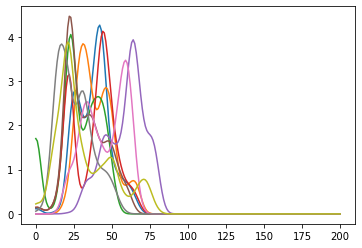

In [1119]:
for i in adjacency_distributions:
    plt.plot(i)

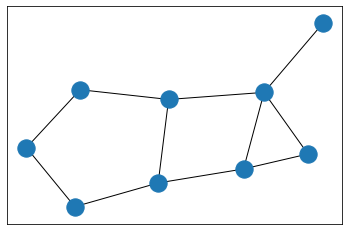

In [1133]:
idx = onp.random.randint(len(many_EDMs))
d = jax_squareform(many_EDMs[idx])
A = squared_exponential(d)-np.eye(9)
lt = np.array(np.less_equal(d, 1.75), dtype='int32')
gt = np.array(np.greater_equal(d, 0.01), dtype='int32')
A = np.bitwise_and(lt, gt)
import networkx as nx
g = nx.from_numpy_array(A)
#nx.draw(g)
edgewidth = [ d['weight'] for (u,v,d) in g.edges(data=True)]
# layout
pos = nx.spring_layout(g, iterations=50)
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos, width=edgewidth*2,)

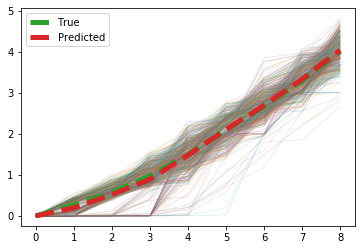

In [1134]:
el = list()
for d in many_EDMs:
    evals, _ = getConnectivity(jax_squareform(d))
    
    plt.plot(evals, linewidth=0.25, alpha=0.5)
    el.append(evals)
    
el = np.array(el)
true_evecs = eigvals
plt.plot(np.mean(true_evecs,axis=0), linewidth=5, linestyle='--', label='True')
plt.plot(np.mean(el,axis=0), linewidth=5, linestyle='--', label='Predicted')
plt.legend()

5.528001
4.5190587


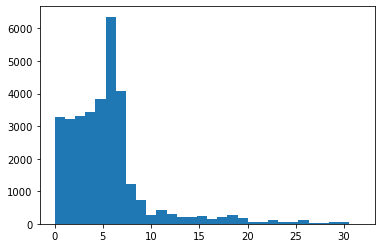

In [1135]:
plt.hist(E_fn(many_coords)[np.triu_indices(256,1)], bins=30)
print(np.mean(E_fn(many_coords)[np.triu_indices(256,1)]))
print(np.std(E_fn(many_coords)[np.triu_indices(256,1)]))

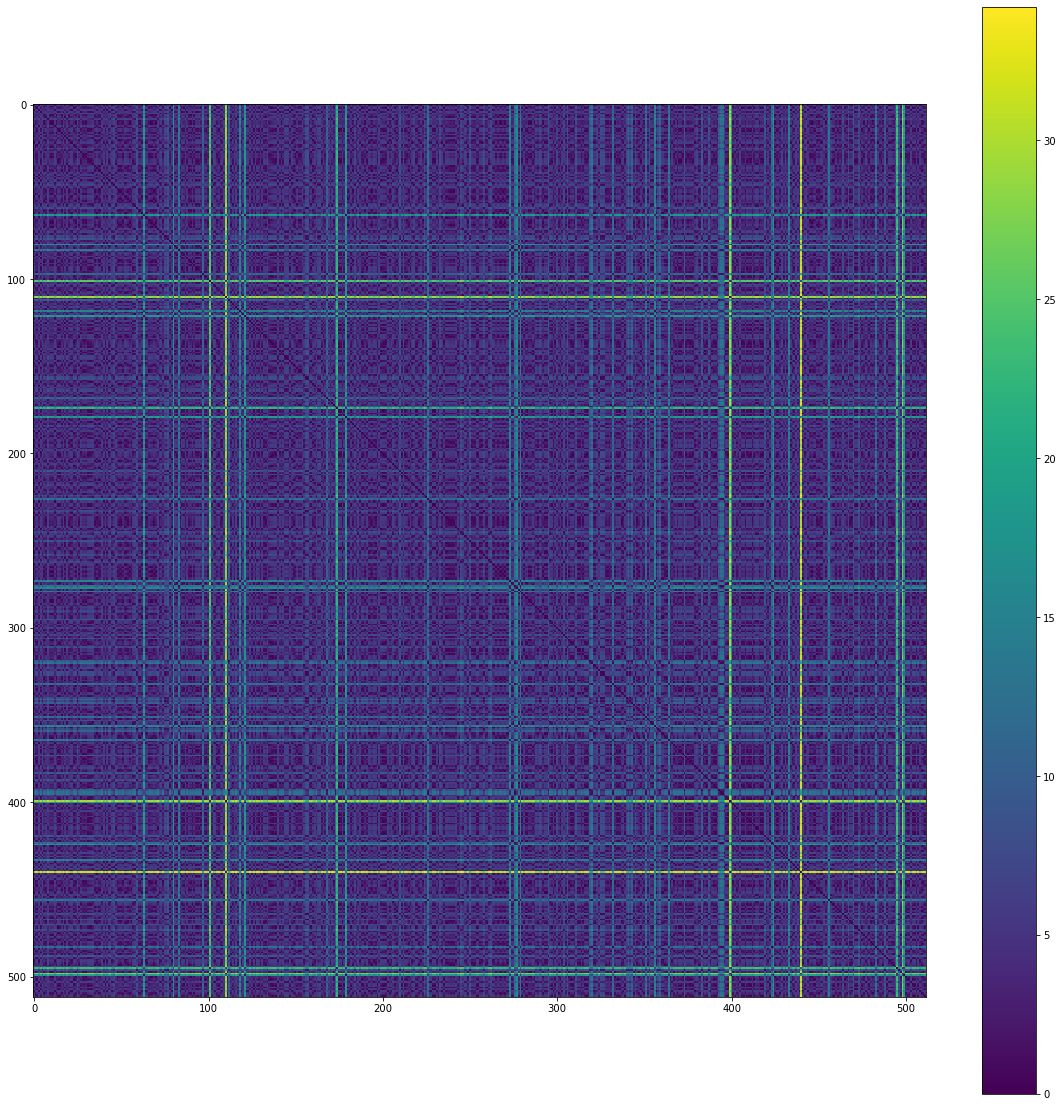

In [1136]:
plt.figure(figsize=(20,20))
plt.imshow(E_fn(many_coords))
plt.colorbar()

# How do the coordinates look?

Predict some coordinates and plot to see if they are at least consistent with the expected radial distribution function. 

In [1139]:
many_EDMs

DeviceArray([[1.7318323, 2.5115247, 2.906157 , ..., 1.7587068, 1.7946188,
              1.8530315],
             [1.0503829, 2.1580212, 4.0469036, ..., 1.6616218, 1.6661146,
              1.9760228],
             [1.4667968, 2.6765585, 4.3957343, ..., 2.5169282, 1.6447434,
              1.6939905],
             ...,
             [1.5212675, 2.3502343, 2.4210954, ..., 1.6646134, 1.3265116,
              2.0727038],
             [1.058831 , 2.1888695, 4.0170064, ..., 1.6555688, 1.6607573,
              2.024443 ],
             [1.7211944, 2.9402847, 4.2667627, ..., 2.8569994, 1.4962183,
              1.5176868]], dtype=float32)

In [445]:
#Neater:
#https://github.com/google/jax/issues/1397
    
#edm = squareform(all_distances[1])
d = 
edm = squareform(distances)    

def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = edm**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


ValueError: The matrix argument must be square.

In [1155]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz, fudgeFactor):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*fudgeFactor
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*fudgeFactor
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


--------------
_Remember_ - you can use either the EDM-coords or the real coordinates to generate a molecule



Somehow these are different. They should be the same!!

In [1243]:
idx = onp.random.randint(len(many_EDMs))
distance_matrix = sigm(jax_squareform(many_EDMs[idx]))

0 1
0 4
0 6
1 4
1 6
3 5
4 6
7 8


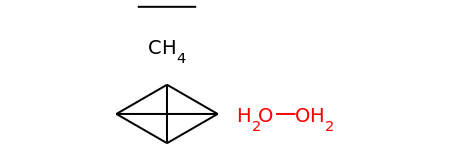

In [1244]:

atomicNumList = [6]*7+[8]*2

mol = get_proto_mol(atomicNumList)
eMol = Chem.EditableMol(mol)

am = np.array(distance_matrix>0.3).astype(int)-np.eye(9)
bonds = np.triu(am)
for j, k in zip(onp.where(bonds)[0], onp.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None
        
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

In [1238]:
mol.Compute3DCoords()
mol

AttributeError: 'Mol' object has no attribute 'Compute3DCoords'